This code calculates various methods of historical volatility from stock price data. It downloads historical prices for Apple Inc. (AAPL) and computes returns. The code then defines functions to compute volatility using different models: Parkinson, Garman-Klass, Hodges-Tompkins, Rogers-Satchell, Yang-Zhang, and standard deviation. Each model is applied to the data, and the results are plotted for visualization. This is useful for risk management, option pricing, and financial analysis.

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.2 MB/s eta 0:00:0000:0100:01
  Created wheel for peewee: filename=peewee-3.18.1-py3-none-any.whl size=139051 sha256=b01929c1afbb64a777608cc4ca7983f1023fe7818c6baf43bf9448b136874ca0
  Stored in directory: /root/.cache/pip/wheels/25/cb/79/a133a0d1d75f318a96614ed7fb97bdf2f35a7b6c4d4e426e3f
Successfully built peewee

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [50]:
import math
import numpy as np
import pandas as pd
import yfinance as yf

Download historical stock data for Apple Inc. (AAPL) from Yahoo Finance

In [3]:
data = yf.download("AAPL", start="2017-01-01", end="2022-06-30")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Display the downloaded stock data

In [8]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2017-01-03,26.862427,26.904056,26.540957,26.781481,115127600
2017-01-04,26.832355,26.945681,26.769912,26.793039,84472400
2017-01-05,26.968811,27.026629,26.783791,26.809232,88774400
2017-01-06,27.269468,27.327287,26.936434,27.008128,127007600
2017-01-09,27.519243,27.621004,27.276407,27.278719,134247600


In [9]:
data.index.min(), data.index.max()

(Timestamp('2017-01-03 00:00:00'), Timestamp('2022-06-29 00:00:00'))

In [10]:
data.describe()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,1382.000000,1382.000000,1382.000000,1382.000000,1.382000e+03
mean,79.863698,80.727353,78.929959,79.811428,1.186585e+08
std,45.761011,46.353051,45.142081,45.754065,5.455137e+07
min,26.832355,26.904056,26.540957,26.781481,4.100000e+07
25%,41.114903,41.319059,40.748316,41.032651,8.328732e+07
50%,54.245333,54.947681,53.879867,54.446929,1.043836e+08
75%,123.639238,125.151414,122.580864,123.957074,1.375076e+08
max,178.879898,179.793936,176.039622,179.489269,4.479400e+08


Calculate daily returns from adjusted closing prices

<Axes: xlabel='Date'>

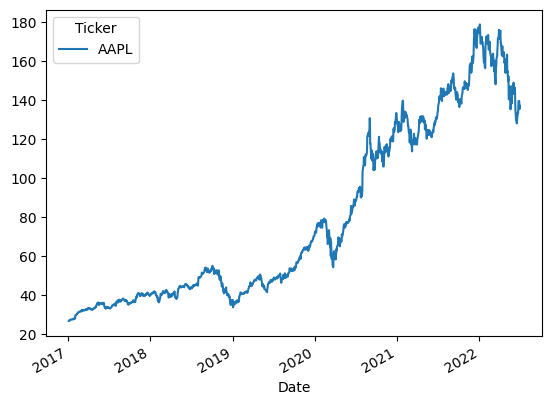

In [13]:
data["Close"].plot()

<Axes: xlabel='Date'>

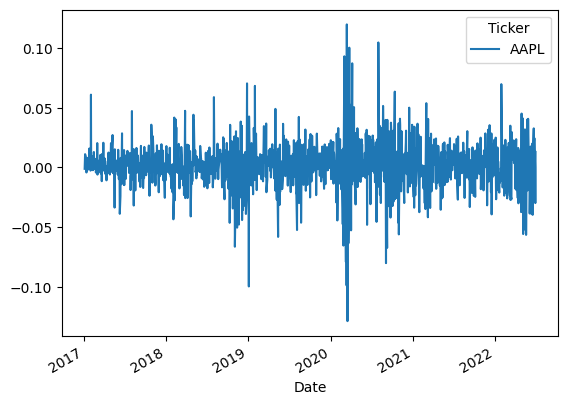

In [14]:
returns = (data["Close"] / data["Close"].shift(1)) - 1
returns.plot()

In [17]:
# Compare manual calculation with pct_change method in pandas
returns_pct = data["Close"].pct_change()
(returns-returns_pct).describe()

Ticker,AAPL
count,1381.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [19]:
# Comparison of log-returns calculations
log_returns_1 = np.log(1.0 + returns)
log_returns_2 = np.log(data["Close"]/data["Close"].shift())
(log_returns_1-log_returns_2).describe()

Ticker,AAPL
count,1381.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


# Volatility estimators

## Standard deviation

Ref: https://portfolioslab.com/tools/close-to-close-volatility and https://en.wikipedia.org/wiki/Volatility_(finance)

**How to annualize the volatility?**

* Let's work with log-returns.
* Assuming 252 trading days and that all daily returns $r_i$ for $i \in [1, 252]$ are iid, the annual return $r_Y = \sum_{i=1}^{252} r_i$.
* Because all daily returns are iid, we have $Var[r_Y] = 252 Var[r_i] = 252 \sigma_d^2$, where $\sigma_d$ is the variance of the daily returns $r_i$.
* And therefore, writting the annual volatility as $\sigma_Y$, we have the relationship between annual and daily volatility (assuming 252 trading days),
$\sigma_Y = \sqrt{252} \sigma_d$.

In [45]:
rolling_window_length = 30
annualized_vol = np.sqrt(252) * log_returns_1.rolling(window=rolling_window_length, center=False).std()

<Axes: xlabel='Date'>

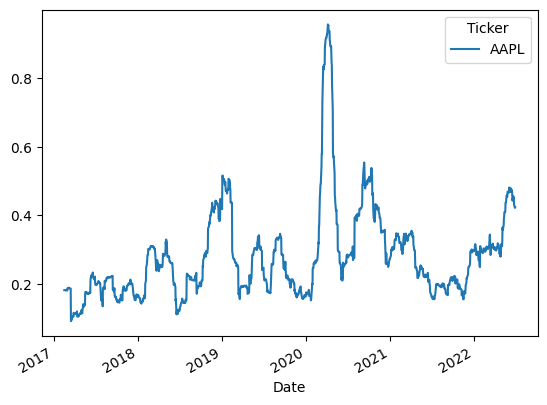

In [46]:
annualized_vol.plot()

## Parkinson volatility

Ref: https://portfolioslab.com/tools/parkinson
and an article about its application in trading: https://www.bestexresearch.com/insights/standard-vs-parkinson-volatility-for-execution-algorithms-understanding-the-trade-offs

In [65]:
rolling_window_length = 30
hilow_log_returns = np.log(data["High"]/data["Low"])
annualized_parkinson_vol = np.sqrt(252) * np.sqrt((hilow_log_returns**2).rolling(window=rolling_window_length, center=False).sum() 
                                                  / (4*rolling_window_length*np.log(2.0)))

<Axes: xlabel='Date'>

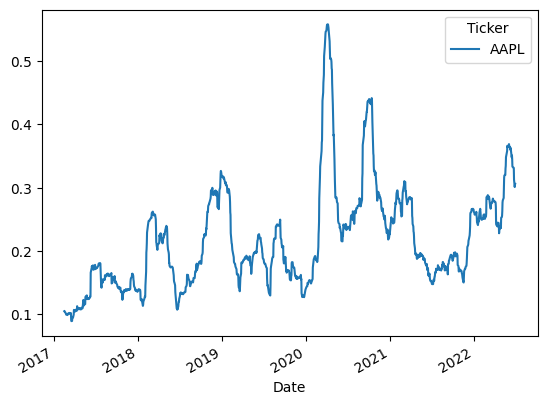

In [66]:
annualized_parkinson_vol.plot()

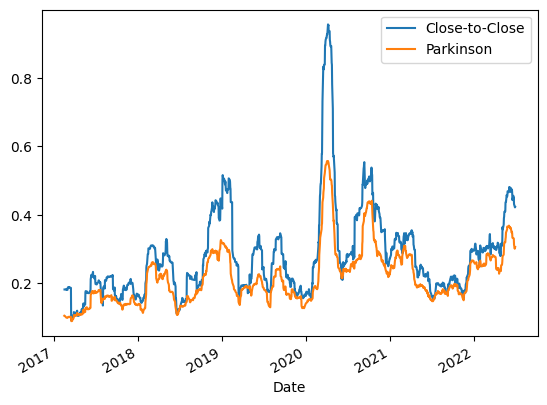

In [67]:
ax = pd.concat([annualized_vol, annualized_parkinson_vol], axis=1).plot()
ax.legend(['Close-to-Close', 'Parkinson'])

## Garman Klass

Ref: https://portfolioslab.com/tools/garman-klass

In [68]:
rolling_window_length = 30
hilow_log_returns = np.log(data["High"]/data["Low"])
openclose_log_returns = np.log(data["Close"]/data["Open"])
annualized_garmanklass_vol = \
np.sqrt(252) * np.sqrt(
    (hilow_log_returns**2 / (2*rolling_window_length)
     - openclose_log_returns**2 * (2*np.log(2)-1)/rolling_window_length
    ).rolling(window=rolling_window_length, center=False).sum()
)

<Axes: xlabel='Date'>

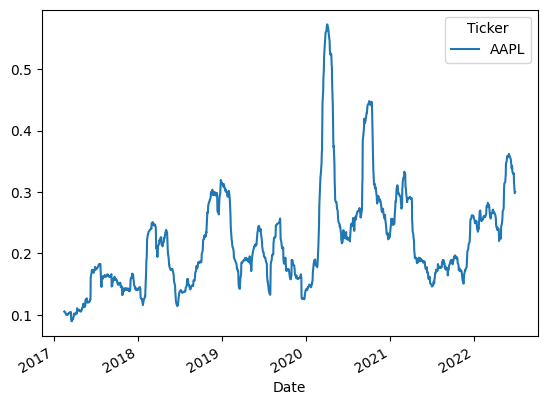

In [69]:
annualized_garmanklass_vol.plot()

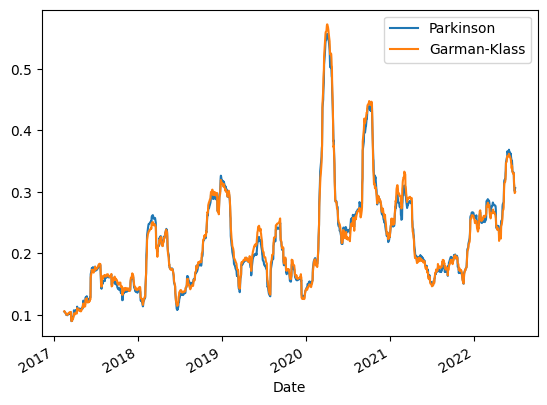

In [71]:
ax = pd.concat([annualized_parkinson_vol, annualized_garmanklass_vol], axis=1).plot()
ax.legend(['Parkinson', 'Garman-Klass'])

## Rogers Satchell

Ref: https://portfolioslab.com/tools/rogers-satchell

In [109]:
rolling_window_length = 30

highclose_log_returns = np.log(data["High"]/data["Close"])
highopen_log_returns = np.log(data["High"]/data["Open"])
lowclose_log_returns = np.log(data["Low"]/data["Close"])
lowopen_log_returns = np.log(data["Low"]/data["Open"])

annualized_rogerssatchell_vol = np.sqrt(252/rolling_window_length * \
(highclose_log_returns*highopen_log_returns + lowclose_log_returns*lowopen_log_returns).rolling(window=rolling_window_length, center=False).sum())

<Axes: xlabel='Date'>

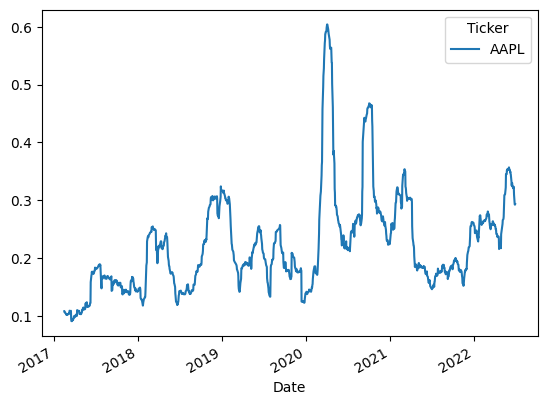

In [110]:
annualized_rogerssatchell_vol.plot()

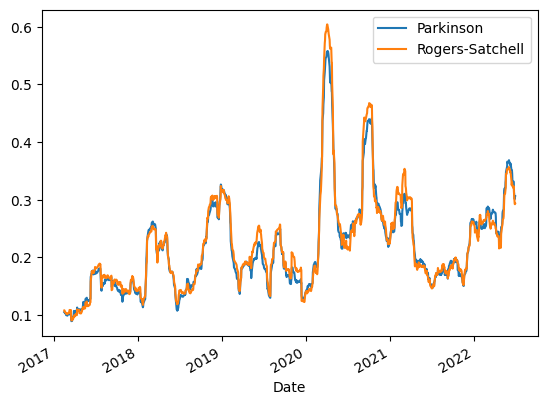

In [111]:
ax = pd.concat([annualized_parkinson_vol, annualized_rogerssatchell_vol], axis=1).plot()
ax.legend(['Parkinson', 'Rogers-Satchell'])

## Yang-Zhang volatility

Ref: https://portfolioslab.com/tools/yang-zhang

In [112]:
alpha = 0.34
k = (alpha-1)/(alpha + (rolling_window_length+1)/(rolling_window_length-1))

In [113]:
opencloselag_log_returns = np.log(data["Open"]/data["Close"].shift())
overnight_var = opencloselag_log_returns.rolling(window=rolling_window_length).var(ddof=1)

In [114]:
openclose_log_returns = np.log(data["Close"]/data["Open"])
openclose_var = openclose_log_returns.rolling(window=rolling_window_length).var(ddof=1)

In [115]:
annualized_yangzhang_vol = \
np.sqrt(252*(overnight_var + k*openclose_var) + (1-k) * annualized_rogerssatchell_vol**2)

<Axes: xlabel='Date'>

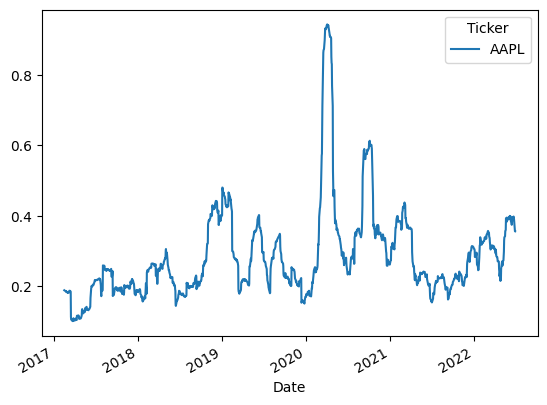

In [116]:
annualized_yangzhang_vol.plot()

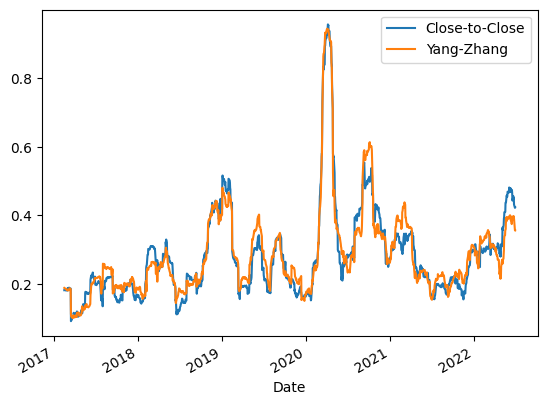

In [118]:
ax = pd.concat([annualized_vol, annualized_yangzhang_vol], axis=1).plot()
ax.legend(['Close-to-Close', 'Yang-Zhang'])

# Original

Plot the adjusted closing prices over time

In [39]:
def parkinson(price_data, window=30, trading_periods=252, clean=True):
    """Calculate volatility using the Parkinson model

    Parameters
    ----------
    price_data : DataFrame
        Historical stock price data
    window : int, optional
        Rolling window size in days (default is 30)
    trading_periods : int, optional
        Number of trading periods per year (default is 252)
    clean : bool, optional
        Whether to drop NaN values in the result (default is True)

    Returns
    -------
    Series
        Parkinson volatility
    """

    # Calculate the Parkinson volatility estimate using high and low prices
    rs = (1.0 / (4.0 * math.log(2.0))) * (
        (price_data["High"] / price_data["Low"]).apply(np.log)
    ) ** 2.0

    # Define a function to apply the rolling mean and scale by trading periods
    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    # Apply the rolling window calculation to the Parkinson estimate
    result = rs.rolling(window=window, center=False).apply(func=f)

    # Return the cleaned result or the full result based on the 'clean' parameter
    if clean:
        return result.dropna()
    else:
        return result

Plot Parkinson volatility over time

<Axes: xlabel='Date'>

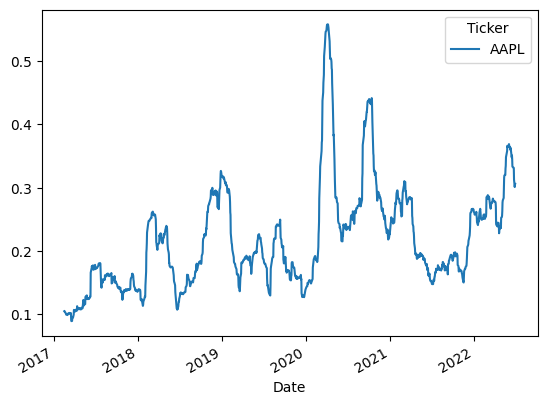

In [40]:
parkinson(data).plot()

In [72]:
def garman_klass(price_data, window=30, trading_periods=252, clean=True):
    """Calculate volatility using the Garman-Klass model

    Parameters
    ----------
    price_data : DataFrame
        Historical stock price data
    window : int, optional
        Rolling window size in days (default is 30)
    trading_periods : int, optional
        Number of trading periods per year (default is 252)
    clean : bool, optional
        Whether to drop NaN values in the result (default is True)

    Returns
    -------
    Series
        Garman-Klass volatility
    """

    # Calculate log returns of high/low and close/open prices
    log_hl = (price_data["High"] / price_data["Low"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    # Compute the Garman-Klass volatility estimate
    rs = 0.5 * log_hl**2 - (2 * math.log(2) - 1) * log_co**2

    # Define a function to apply the rolling mean and scale by trading periods
    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    # Apply the rolling window calculation to the Garman-Klass estimate
    result = rs.rolling(window=window, center=False).apply(func=f)

    # Return the cleaned result or the full result based on the 'clean' parameter
    if clean:
        return result.dropna()
    else:
        return result

Plot Garman-Klass volatility over time

<Axes: xlabel='Date'>

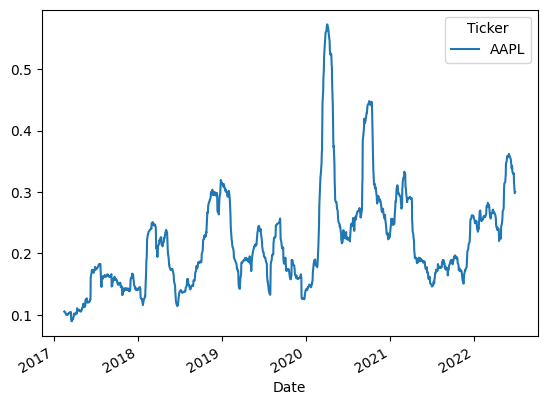

In [73]:
garman_klass(data).plot()

In [ ]:
def hodges_tompkins(price_data, window=30, trading_periods=252, clean=True):
    """Calculate volatility using the Hodges-Tompkins model

    Parameters
    ----------
    price_data : DataFrame
        Historical stock price data
    window : int, optional
        Rolling window size in days (default is 30)
    trading_periods : int, optional
        Number of trading periods per year (default is 252)
    clean : bool, optional
        Whether to drop NaN values in the result (default is True)

    Returns
    -------
    Series
        Hodges-Tompkins volatility
    """

    # Calculate log returns of closing prices
    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    # Compute the rolling standard deviation and scale by trading periods
    vol = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    # Calculate adjustment factors based on window size and sample size
    h = window
    n = (log_return.count() - h) + 1

    adj_factor = 1.0 / (1.0 - (h / n) + ((h**2 - 1) / (3 * n**2)))

    # Apply the adjustment factor to the volatility estimate
    result = vol * adj_factor

    # Return the cleaned result or the full result based on the 'clean' parameter
    if clean:
        return result.dropna()
    else:
        return result

Plot Hodges-Tompkins volatility over time

In [ ]:
hodges_tompkins(data).plot()

In [ ]:
def rogers_satchell(price_data, window=30, trading_periods=252, clean=True):
    """Calculate volatility using the Rogers-Satchell model

    Parameters
    ----------
    price_data : DataFrame
        Historical stock price data
    window : int, optional
        Rolling window size in days (default is 30)
    trading_periods : int, optional
        Number of trading periods per year (default is 252)
    clean : bool, optional
        Whether to drop NaN values in the result (default is True)

    Returns
    -------
    Series
        Rogers-Satchell volatility
    """

    # Calculate log returns of high/open, low/open, and close/open prices
    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    # Compute the Rogers-Satchell volatility estimate
    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    # Define a function to apply the rolling mean and scale by trading periods
    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    # Apply the rolling window calculation to the Rogers-Satchell estimate
    result = rs.rolling(window=window, center=False).apply(func=f)

    # Return the cleaned result or the full result based on the 'clean' parameter
    if clean:
        return result.dropna()
    else:
        return result

Plot Rogers-Satchell volatility over time

In [ ]:
rogers_satchell(data).plot()

In [95]:
def yang_zhang(price_data, window=30, trading_periods=252, clean=True):
    """Calculate volatility using the Yang-Zhang model

    Parameters
    ----------
    price_data : DataFrame
        Historical stock price data
    window : int, optional
        Rolling window size in days (default is 30)
    trading_periods : int, optional
        Number of trading periods per year (default is 252)
    clean : bool, optional
        Whether to drop NaN values in the result (default is True)

    Returns
    -------
    Series
        Yang-Zhang volatility
    """

    # Calculate log returns of high/open, low/open, close/open, open/close, and close/close prices
    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    log_oc = (price_data["Open"] / price_data["Close"].shift(1)).apply(np.log)
    log_oc_sq = log_oc**2

    log_cc = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)
    log_cc_sq = log_cc**2

    # Compute the Rogers-Satchell volatility estimate
    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    # Compute close-to-close and open-to-close volatilities
    close_vol = log_cc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    open_vol = log_oc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    window_rs = rs.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0))

    # Calculate the weighting factor 'k'
    k = 0.34 / (1.34 + (window + 1) / (window - 1))

    # Compute the final Yang-Zhang volatility estimate
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(
        np.sqrt
    ) * math.sqrt(trading_periods)

    # Return the cleaned result or the full result based on the 'clean' parameter
    if clean:
        return result.dropna()
    else:
        return result

Plot Yang-Zhang volatility over time

<Axes: xlabel='Date'>

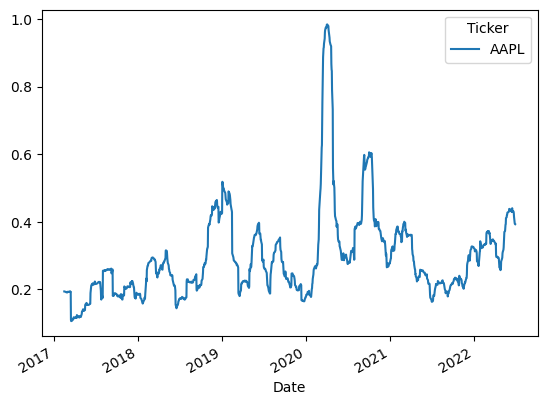

In [96]:
yang_zhang(data).plot()

In [26]:
def standard_deviation(price_data, window=30, trading_periods=252, clean=True):
    """Calculate volatility using standard deviation of log returns

    Parameters
    ----------
    price_data : DataFrame
        Historical stock price data
    window : int, optional
        Rolling window size in days (default is 30)
    trading_periods : int, optional
        Number of trading periods per year (default is 252)
    clean : bool, optional
        Whether to drop NaN values in the result (default is True)

    Returns
    -------
    Series
        Standard deviation volatility
    """

    # Calculate log returns of closing prices
    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    # Compute the rolling standard deviation and scale by trading periods
    result = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    # Return the cleaned result or the full result based on the 'clean' parameter
    if clean:
        return result.dropna()
    else:
        return result

Plot standard deviation volatility over time

<Axes: xlabel='Date'>

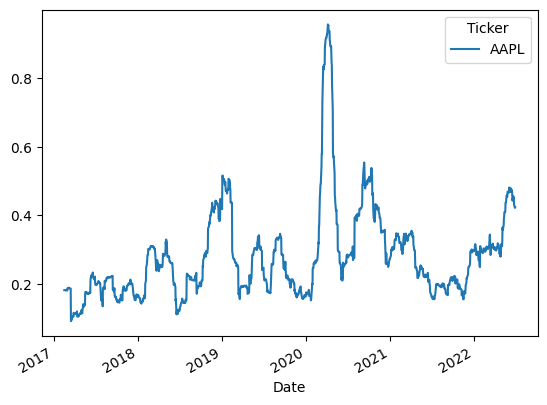

In [27]:
standard_deviation(data).plot()

<a href="https://pyquantnews.com/">PyQuant News</a> is where finance practitioners level up with Python for quant finance, algorithmic trading, and market data analysis. Looking to get started? Check out the fastest growing, top-selling course to <a href="https://gettingstartedwithpythonforquantfinance.com/">get started with Python for quant finance</a>. For educational purposes. Not investment advise. Use at your own risk.